### Loading the Dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 407MB/s]


In [4]:
!unzip telco-customer-churn.zip

Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


### Importing libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

### Understanding of the Data

In [6]:
df = pd.read_csv('telco-customer-churn.zip')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
df.shape

(7043, 21)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Total charger datatype is incorrect here it should float

### Statistical Summary

In [9]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [10]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


### Checking Duplicates

In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df_new = df.copy()

### Handling Incorrect datatype

In [13]:
df_new['SeniorCitizen'] = df_new['SeniorCitizen'].map({0: 'No', 1: 'Yes'})
# is is fine but just to get the better analysis we make it object later we will d o encoding on this

In [14]:
df_new['SeniorCitizen'].dtypes

dtype('O')

In [15]:
df_new['TotalCharges'] = pd.to_numeric(df_new['TotalCharges'], errors='coerce')

In [16]:
df_new['TotalCharges'].dtypes

dtype('float64')

In [17]:
df_new['TotalCharges'].isnull().sum()
#After correcting the datatype there aee 11 missing values

np.int64(11)

### Handling missing values
As in monthly charges there is not any missing value so we will impute it by monthlycharges x tenure = totalcharges

In [18]:
filt = df_new.loc[df_new['TotalCharges'].isnull(), ['MonthlyCharges', 'tenure', 'TotalCharges']]
df_new['TotalCharges'] = df_new['TotalCharges'].fillna(filt['MonthlyCharges']*filt['tenure'])

The missing rows are basically those rows who joins a while ago their tenure is 0 so the total cheges should be 0 as well

### Dropping Irrelevant Feature

In [19]:
df_new = df_new.drop(columns='customerID', axis=1)

# Analysis of the dataset

### Analyze the target columns

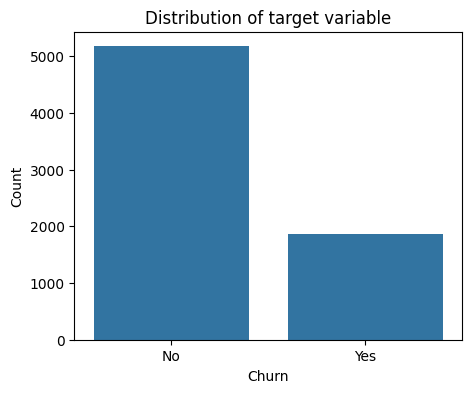

In [20]:
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df_new)
plt.title('Distribution of target variable')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

In [21]:
df_new['Churn'].value_counts(normalize=True)*100

,proportion
Churn,
No,73.463013
Yes,26.536987


Almost 26% customers are likely to churn

## Univariate analysis
Analyze all the categorical columns individually

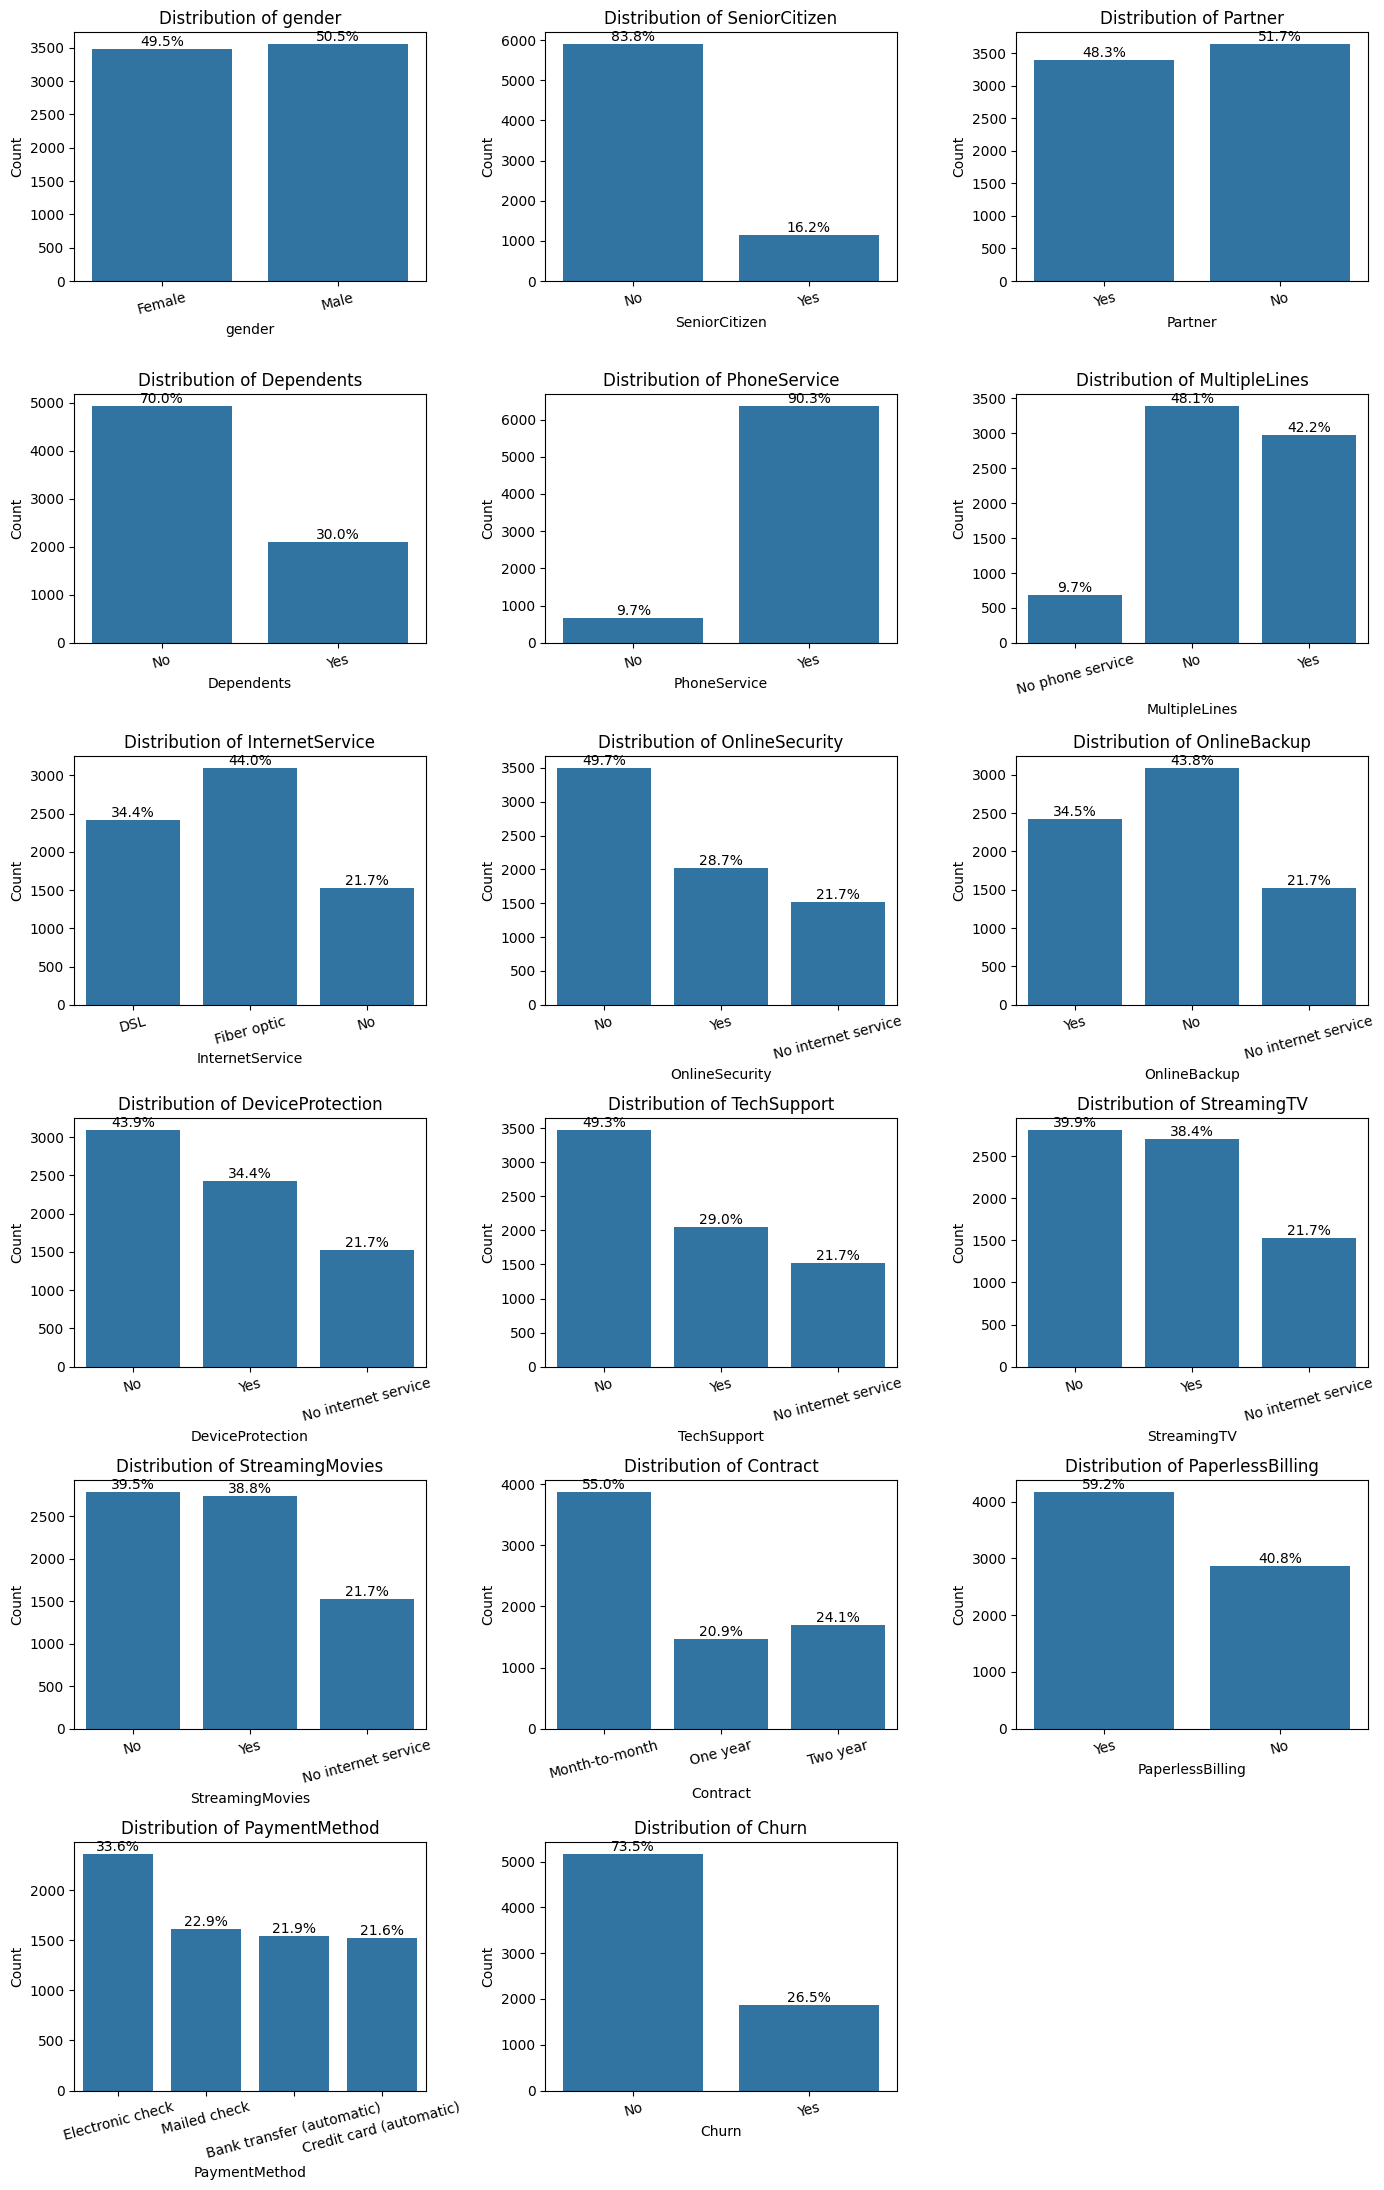

In [22]:
df_new_categoric = df_new.select_dtypes(include='object')
plt.figure(figsize=(14,22))
for i, col in enumerate(df_new_categoric.columns, 1):
  plt.subplot(6, 3, i)
  ax = sns.countplot(x=col, data = df_new)
  plt.title(f'Distribution of {col}')
  plt.xlabel(f'{col}')
  plt.ylabel('Count')
  for p in ax.patches:
    count = p.get_height()
    percentage = count / len(df_new) * 100
    x = p.get_x() + p.get_width() / 2
    y = count + 0.1
    plt.text(x, y, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)
  plt.xticks(rotation=15)

plt.tight_layout(h_pad=1)
plt.show()

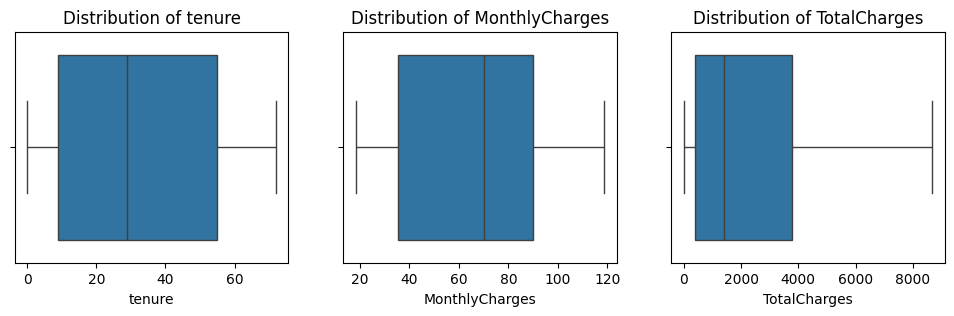

In [23]:
df_new_numeric = df_new.select_dtypes(include=['int', 'float'])
plt.figure(figsize=(12, 3))
for i, col in enumerate(df_new_numeric.columns, 1):
  plt.subplot(1,3,i)
  sns.boxplot(x = col, data=df_new)
  plt.title(f'Distribution of {col}')
  plt.xlabel(f'{col}')
plt.show()

No outliers\
Tenure is slightly positively skewed \
TotalCharges is highly positively skewed\
MonthlyCharges is slightly negatively skewed

## Bivariate Analysis
with Target variable (Churn)

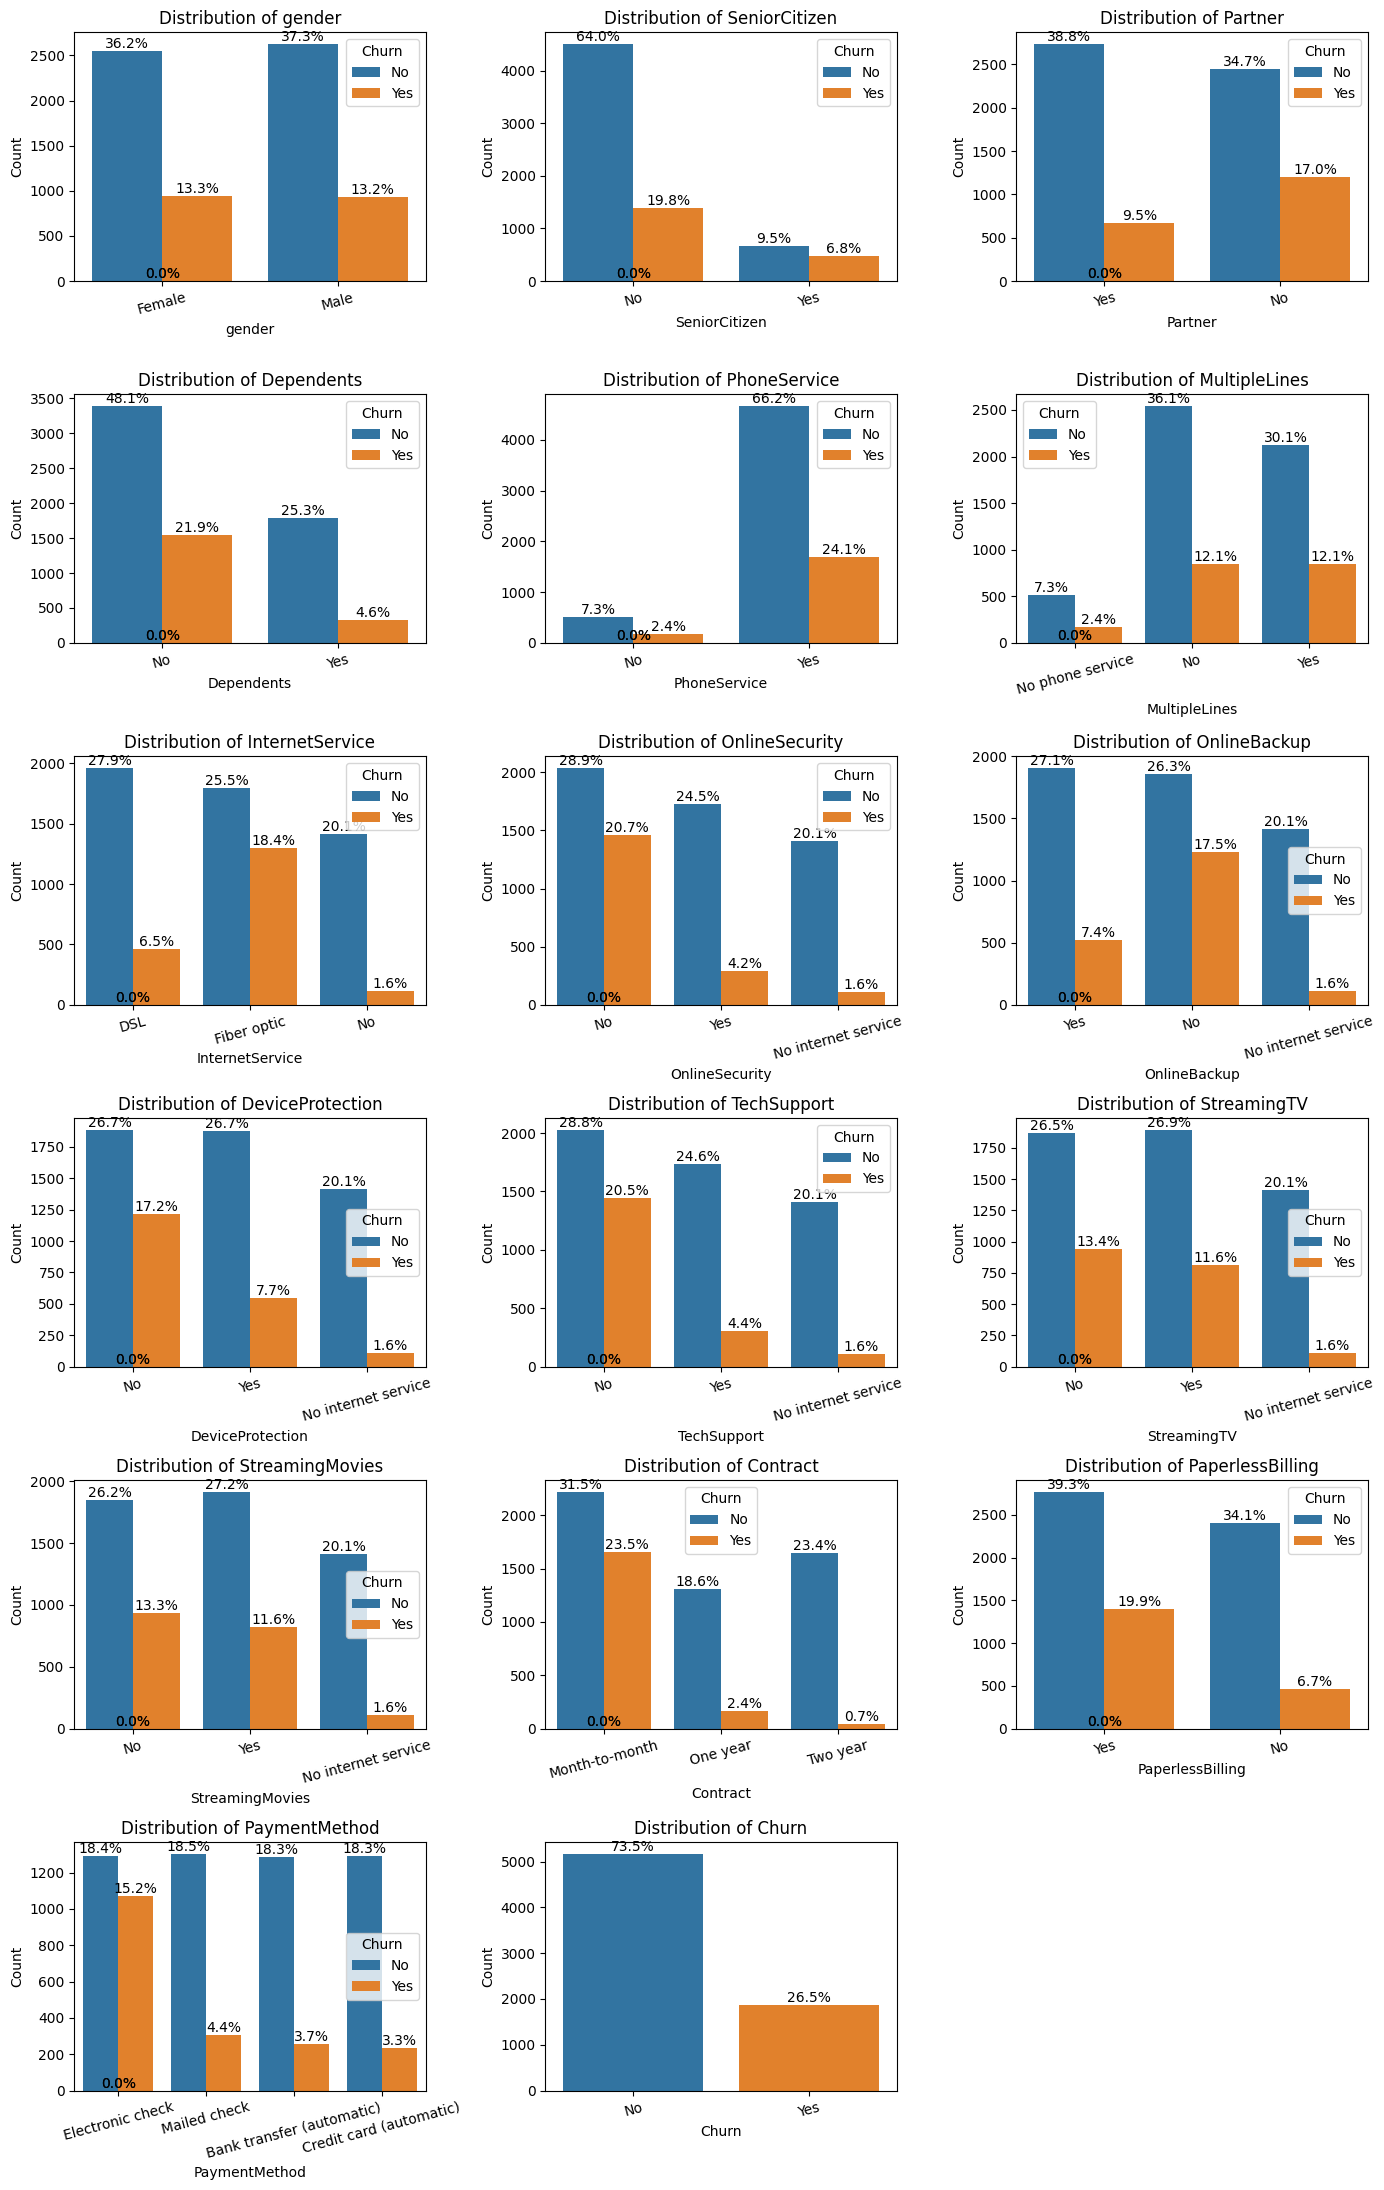

In [24]:
df_new_categoric = df_new.select_dtypes(include='object')
plt.figure(figsize=(14,22))
for i, col in enumerate(df_new_categoric.columns, 1):
  plt.subplot(6, 3, i)
  ax = sns.countplot(x=col, hue='Churn', data = df_new)
  plt.title(f'Distribution of {col}')
  plt.xlabel(f'{col}')
  plt.ylabel('Count')
  for p in ax.patches:
    count = p.get_height()
    percentage = count / len(df_new) * 100
    x = p.get_x() + p.get_width() / 2
    y = count + 0.1
    plt.text(x, y, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)
  plt.xticks(rotation=15)

plt.tight_layout(h_pad=1)
plt.show()

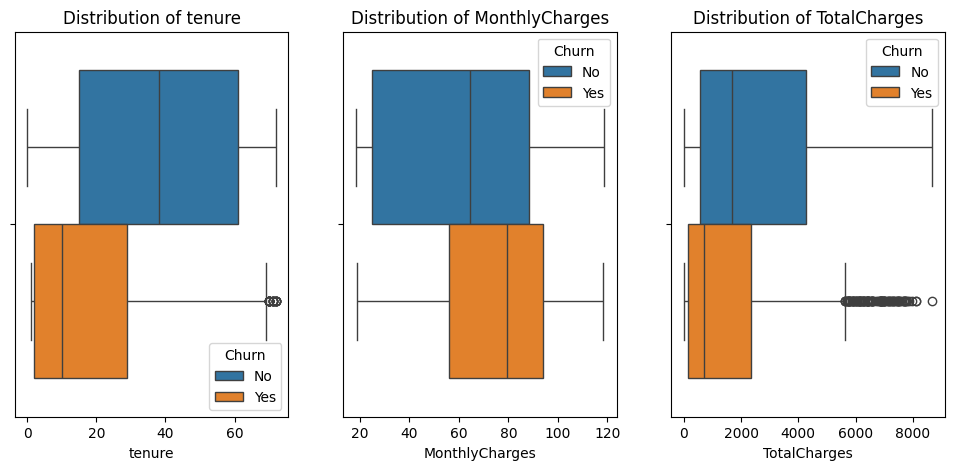

In [25]:
df_new_numeric = df_new.select_dtypes(include=['int', 'float'])
plt.figure(figsize=(12, 5))
for i, col in enumerate(df_new_numeric.columns, 1):
  plt.subplot(1,3,i)
  sns.boxplot(x = col, hue='Churn', data=df_new)
  plt.title(f'Distribution of {col}')
  plt.xlabel(f'{col}')
plt.show()

Those who have less tenure and and less total charges are higher churners
Churners with higher tenure and total charges are in less amomunt

### Numerical Analysis

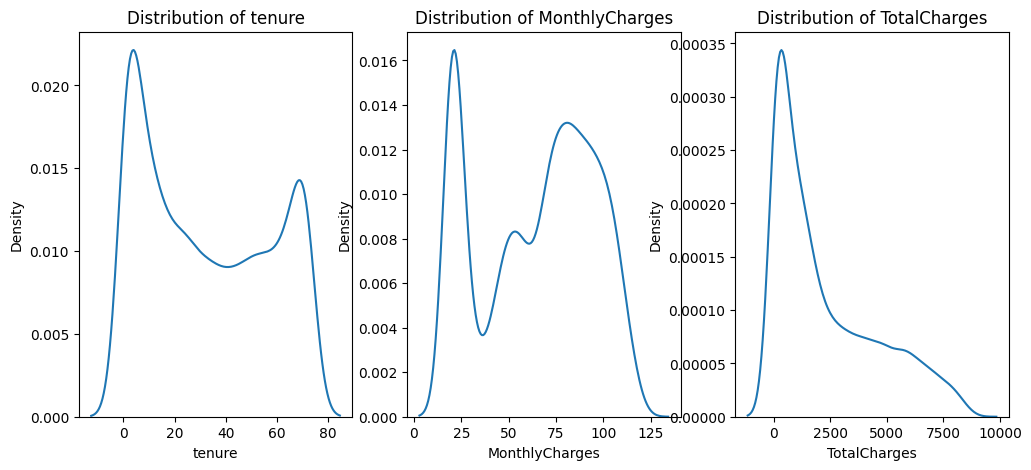

In [26]:
df_new_numeric = df_new.select_dtypes(include=['int', 'float'])
plt.figure(figsize=(12, 5))
for i, col in enumerate(df_new_numeric.columns, 1):
  plt.subplot(1,3,i)
  sns.kdeplot(x = col, data=df_new)
  plt.title(f'Distribution of {col}')
  plt.xlabel(f'{col}')
plt.show()

In [27]:
for i in df_new_numeric.columns:
  skew = df_new[i].skew()
  print(f'{i}: {skew}')

tenure: 0.2395397495619829
MonthlyCharges: -0.22052443394398033
TotalCharges: 0.963234654832277


## Splitting The data

In [28]:
X = df_new.drop(columns='Churn')
Y = df_new['Churn']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [29]:
len(X_train)
len(X_test)

1409

In [30]:
Y_train.value_counts(normalize=True)
Y_test.value_counts(normalize=True)
# Both have same ratio due to statify
# also class is imbalance

,proportion
Churn,
No,0.734564
Yes,0.265436


### Feature Encoding

In [31]:
X_train_categoric = X_train.select_dtypes(include='object')
X_train_numeric = X_train.select_dtypes(include=['int', 'float'])

X_test_categoric = X_test.select_dtypes(include='object')
X_test_numeric = X_test.select_dtypes(include=['int', 'float'])

In [32]:
One_hot = OneHotEncoder(drop='first', sparse_output=False)
X_train_categoric = pd.DataFrame(One_hot.fit_transform(X_train_categoric), columns=One_hot.get_feature_names_out(X_train_categoric.columns), index=X_train_categoric.index)
X_test_categoric =  pd.DataFrame(One_hot.transform(X_test_categoric), columns=One_hot.get_feature_names_out(X_test_categoric.columns), index=X_test_categoric.index)

In [33]:
X_train_encode = pd.concat([X_train_numeric, X_train_categoric], axis=1)
X_test_encode = pd.concat([X_test_numeric, X_test_categoric], axis=1)

In [34]:
X_train_encode.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3738,35,49.20,1701.65,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3151,15,75.10,1151.55,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4860,13,40.55,590.35,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3867,26,73.50,1905.70,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
3810,1,44.55,44.55,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [35]:
Y_train_encoded = Y_train.map({'No': 0, 'Yes': 1})
Y_test_encoded = Y_test.map({'No': 0, 'Yes': 1})

### Feature Scaling

In [36]:
X_train_scaled = X_train_encode.copy()
X_test_scaled = X_test_encode.copy()
scaler = StandardScaler()
X_train_scaled[['tenure', 'MonthlyCharges']] = scaler.fit_transform(X_train_scaled[['tenure', 'MonthlyCharges']])
X_test_scaled[['tenure', 'MonthlyCharges']] = scaler.transform(X_test_scaled[['tenure', 'MonthlyCharges']])

In [37]:
yeo = PowerTransformer(method='yeo-johnson')
X_train_scaled['TotalCharges'] = yeo.fit_transform(X_train[['TotalCharges']])
X_test_scaled['TotalCharges'] = yeo.transform(X_test_scaled[['TotalCharges']])

In [38]:
X_train_scaled.head(3)

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3738,0.102371,-0.521976,0.163483,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3151,-0.711743,0.337478,-0.127790,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4860,-0.793155,-0.809013,-0.562790,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Before Balancing the Class

In [39]:
def before_balancing(model):
  scores = cross_val_score(model, X_train_scaled, Y_train_encoded, cv=5)
  print('Cross Validation Scores: ',scores)

  print('\nTraining scores')
  model.fit(X_train_scaled, Y_train_encoded)
  Y_pred = model.predict(X_train_scaled)
  score = classification_report(Y_train_encoded, Y_pred)
  print(score)

  print('\nTest scores')
  model.fit(X_train_scaled, Y_train_encoded)
  Y_pred = model.predict(X_test_scaled)
  score = classification_report(Y_test_encoded, Y_pred)
  print(score)
  cm = confusion_matrix(Y_test_encoded, Y_pred)
  plt.figure(figsize=(4,4))
  sns.heatmap(cm, annot=True, fmt='d', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix Heatmap')
  plt.show()

Cross Validation Scores:  [0.82874889 0.81277728 0.80745342 0.79236912 0.80195382]

Training scores
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4139
           1       0.68      0.54      0.60      1495

    accuracy                           0.81      5634
   macro avg       0.76      0.72      0.74      5634
weighted avg       0.80      0.81      0.80      5634


Test scores
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



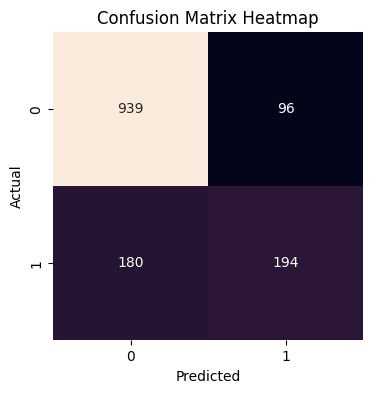

In [40]:
lr = LogisticRegression(random_state=42)
before_balancing(lr)

Cross Validation Scores:  [0.7905945  0.78793256 0.78793256 0.77994676 0.76198934]

Training scores
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4139
           1       0.65      0.56      0.60      1495

    accuracy                           0.80      5634
   macro avg       0.75      0.73      0.73      5634
weighted avg       0.80      0.80      0.80      5634


Test scores
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



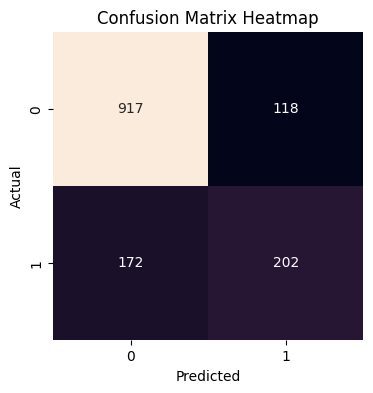

In [41]:
dt = DecisionTreeClassifier(max_depth=5)
before_balancing(dt)

Cross Validation Scores:  [0.82697427 0.81277728 0.80479148 0.78615794 0.79129663]

Training scores
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4139
           1       0.72      0.52      0.60      1495

    accuracy                           0.82      5634
   macro avg       0.78      0.72      0.74      5634
weighted avg       0.81      0.82      0.81      5634


Test scores
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.49      0.56       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



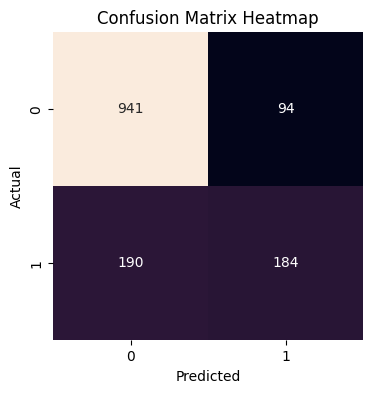

In [42]:
sv = SVC()
before_balancing(sv)

## After Balancing the class

In [43]:
smote = SMOTE(random_state=42)
X_train_scaled_bal, Y_train_encoded_bal = smote.fit_resample(X_train_scaled, Y_train_encoded)

In [44]:
def after_balancing(model):
  scores = cross_val_score(model, X_train_scaled_bal, Y_train_encoded_bal, cv=5)
  print('Cross Validation Scores: ',scores)

  print('\nTraining scores')
  model.fit(X_train_scaled_bal, Y_train_encoded_bal)
  Y_pred = model.predict(X_train_scaled_bal)
  score = classification_report(Y_train_encoded_bal, Y_pred)
  print(score)

  print('\nTest scores')
  model.fit(X_train_scaled_bal, Y_train_encoded_bal)
  Y_pred = model.predict(X_test_scaled)
  score = classification_report(Y_test_encoded, Y_pred)
  print(score)
  cm = confusion_matrix(Y_test_encoded, Y_pred)
  plt.figure(figsize=(4,4))
  sns.heatmap(cm, annot=True, fmt='d', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix Heatmap')
  plt.show()

Cross Validation Scores:  [0.78442029 0.77717391 0.78985507 0.7734139  0.75770393]

Training scores
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      4139
           1       0.76      0.81      0.78      4139

    accuracy                           0.78      8278
   macro avg       0.78      0.78      0.78      8278
weighted avg       0.78      0.78      0.78      8278


Test scores
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



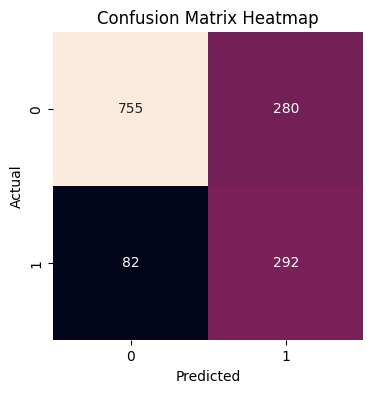

In [45]:
lr = LogisticRegression(random_state=42)
after_balancing(lr)

Cross Validation Scores:  [0.78925121 0.79649758 0.82306763 0.81329305 0.8       ]

Training scores
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      4139
           1       0.80      0.88      0.84      4139

    accuracy                           0.83      8278
   macro avg       0.83      0.83      0.83      8278
weighted avg       0.83      0.83      0.83      8278


Test scores
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.77      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



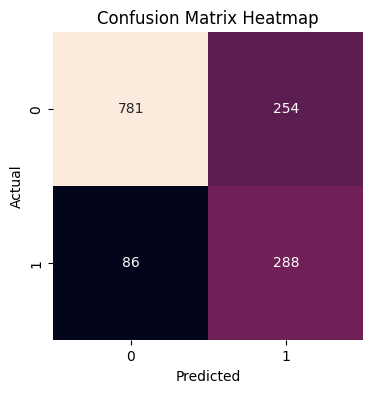

In [46]:
sv = SVC()
after_balancing(sv)

Cross Validation Scores:  [0.75966184 0.76570048 0.80253623 0.79456193 0.77462236]

Training scores
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      4139
           1       0.79      0.79      0.79      4139

    accuracy                           0.79      8278
   macro avg       0.79      0.79      0.79      8278
weighted avg       0.79      0.79      0.79      8278


Test scores
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.71      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409



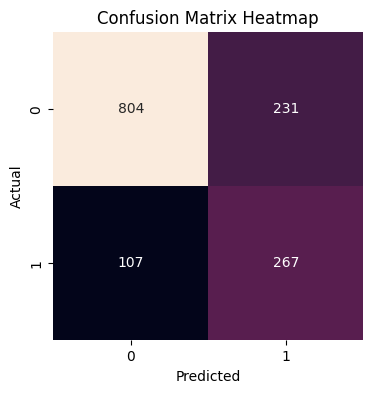

In [47]:
dt = DecisionTreeClassifier(max_depth=5)
after_balancing(dt)

## After Feature Selection
Univariate feature selection

In [48]:
selector = SelectKBest(score_func=f_classif, k=20)  # pick top 20 features
X_new = selector.fit_transform(X_train_scaled, Y_train_encoded)

selected_features = selector.get_support(indices=True)
print("Selected features:", selected_features)

Selected features: [ 0  1  2  4  5  6 10 11 12 13 14 16 18 19 20 22 24 25 26 28]


In [49]:
selected_columns = X_train_scaled.columns[selected_features]
X_train_slected = X_train_scaled[selected_columns]
X_test_selected = X_test_scaled[selected_columns]

In [50]:
def after_selection(model):
  scores = cross_val_score(model, X_train_slected, Y_train_encoded, cv=5)
  print('Cross Validation Scores: ',scores)

  print('\nTraining scores')
  model.fit(X_train_slected, Y_train_encoded)
  Y_pred = model.predict(X_train_slected)
  score = classification_report(Y_train_encoded, Y_pred)
  print(score)

  print('\nTest scores')
  model.fit(X_train_slected, Y_train_encoded)
  Y_pred = model.predict(X_test_selected)
  score = classification_report(Y_test_encoded, Y_pred)
  cm = confusion_matrix(Y_test_encoded, Y_pred)
  print(score)
  plt.figure(figsize=(4,4))
  sns.heatmap(cm, annot=True, fmt='d', cbar=False)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix Heatmap')
  plt.show()

Cross Validation Scores:  [0.81721384 0.8065661  0.80922804 0.78881988 0.79129663]

Training scores
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      4139
           1       0.67      0.52      0.59      1495

    accuracy                           0.81      5634
   macro avg       0.76      0.72      0.73      5634
weighted avg       0.80      0.81      0.80      5634


Test scores
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409



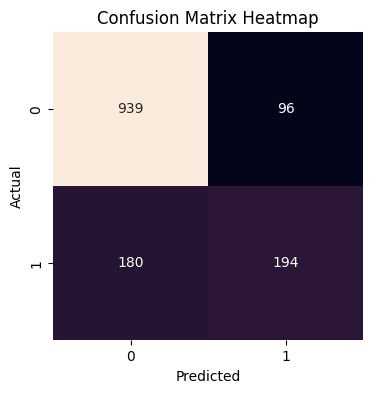

In [51]:
lr = LogisticRegression(random_state=42)
after_selection(lr)

Cross Validation Scores:  [0.8216504  0.80567879 0.80745342 0.79148181 0.79129663]

Training scores
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      4139
           1       0.68      0.51      0.59      1495

    accuracy                           0.81      5634
   macro avg       0.76      0.71      0.73      5634
weighted avg       0.80      0.81      0.80      5634


Test scores
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



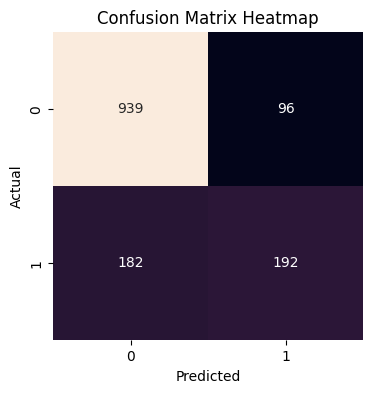

In [52]:
sv = SVC()
after_selection(sv)

Cross Validation Scores:  [0.7905945  0.78881988 0.77994676 0.77373558 0.76198934]

Training scores
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      4139
           1       0.63      0.58      0.61      1495

    accuracy                           0.80      5634
   macro avg       0.74      0.73      0.74      5634
weighted avg       0.79      0.80      0.80      5634


Test scores
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1035
           1       0.62      0.59      0.61       374

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.79      0.80      0.79      1409



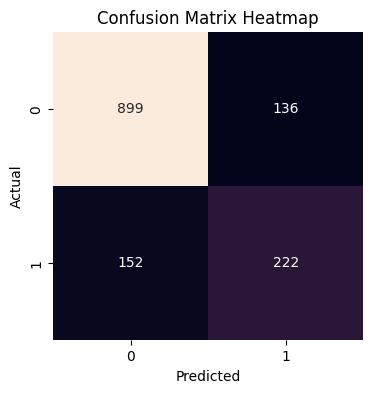

In [53]:
dt = DecisionTreeClassifier(max_depth=5)
after_selection(dt)

Cross Validation Scores:  [0.81455191 0.7985803  0.81632653 0.78615794 0.78507993]

Training scores
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4139
           1       0.72      0.56      0.63      1495

    accuracy                           0.82      5634
   macro avg       0.78      0.74      0.76      5634
weighted avg       0.82      0.82      0.82      5634


Test scores
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



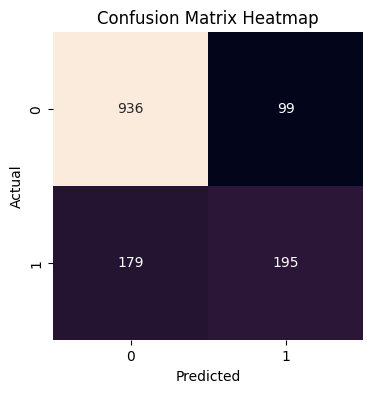

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
Gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)
after_selection(Gb)

## ***Conclusion***
Overall → When we balanced the classes, the models started to overfit because most of the rows in the dataset were duplicates, so the model was memorizing instead of learning.

After applying feature selection, the scores were almost the same as before balancing the classes.

Therefore, we can prefer feature selection because it requires less computational power.